In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector


In [2]:
def get_elevation_along_osm_path(G_osm,path,cursor):
    edge_coordinates,elevations=[],[]
    total_length=0
    for k in range(len(path)-1):
        length=G_osm.get_edge_data(path[k],path[k+1],0)['length']

        cmd="SELECT edge_coordinate,elevation FROM %s WHERE (osm_begin=%i AND osm_end=%i)"%(osm_intersections_table_name,path[k],path[k+1])
        cursor.execute(cmd)
        output=cursor.fetchall()
        if len(output)==0:
            cmd="SELECT edge_coordinate,elevation FROM %s WHERE (osm_end=%i AND osm_begin=%i)"%(osm_intersections_table_name,path[k],path[k+1])
            cursor.execute(cmd)
            output=cursor.fetchall()
            for elem in output:
                elem['edge_coordinate']=length-elem['edge_coordinate']
            
        output=sorted(output,key=lambda elem:elem['edge_coordinate'])
        edge_coordinates+=[total_length+elem['edge_coordinate'] for elem in output]
        elevations+=[elem['elevation'] for elem in output]
        total_length+=length

    return edge_coordinates,elevations

In [3]:

cnx = mysql.connector.connect(user='spirz', 
                              password='this_is_my_PASSWORD_m8',
                              host='localhost',
                              database='dem_from_contours_lines',
                              autocommit=True)
cursor = cnx.cursor(buffered=True,dictionary=True)
contours_lines_table_name='contours_lines'
tree_edges_table_name="tree_edges"
osm_nodes_table_name="osm_nodes"
osm_intersections_table_name="osm_intersections"
2

2

In [4]:
t1=time.time()
cmd="SELECT id,edge_coordinate,elevation,osm_begin,osm_end,osm_key,ST_asText(geometry) AS geometry FROM %s"%osm_intersections_table_name
cursor.execute(cmd)
intersection=pd.DataFrame(cursor.fetchall())
intersection=intersection.set_index('id')
intersection['geometry']=intersection['geometry'].apply(lambda pt:loads(pt))
intersection=gpd.GeoDataFrame(intersection,geometry='geometry',crs='epsg:4326')
t2=time.time()
print(t2-t1)

1.4076228141784668


In [5]:
t1=time.time()
intersection['edge']=intersection.apply(lambda row:(row['osm_begin'],row['osm_end'],row['osm_key']),axis=1)
edges=intersection['edge'].unique()
edges=sorted(edges,key=lambda edge:len(intersection[intersection.edge==edge]))
t2=time.time()
print(t2-t1)

96.55454516410828


In [6]:
intersection

,edge_coordinate,elevation,osm_begin,osm_end,osm_key,geometry,edge
id,,,,,,,
1,384.48100,1600.0,294934188,943065370,0,POINT (9.15569 42.08046),"(294934188, 943065370, 0)"
2,433.78600,1605.0,294934188,943065370,0,POINT (9.15517 42.08025),"(294934188, 943065370, 0)"
3,474.09800,1610.0,294934188,943065370,0,POINT (9.15475 42.08006),"(294934188, 943065370, 0)"
4,547.58800,1615.0,294934188,943065370,0,POINT (9.15416 42.07960),"(294934188, 943065370, 0)"
5,569.68400,1620.0,294934188,943065370,0,POINT (9.15402 42.07972),"(294934188, 943065370, 0)"
...,...,...,...,...,...,...,...
85265,8.65489,95.0,7918406396,9082872188,0,POINT (9.01016 42.61844),"(7918406396, 9082872188, 0)"
85266,120.31100,95.0,7918406389,7918406396,0,POINT (9.01033 42.61854),"(7918406389, 7918406396, 0)"
85267,221.42700,95.0,310478838,5158333731,0,POINT (9.26151 41.63351),"(310478838, 5158333731, 0)"


195
41.99903953547937 9.043377396493366
42.052258945408326 9.027867921679377
min:745.000000, max:1190.000000, d+:445.000000, d-:-315.000000


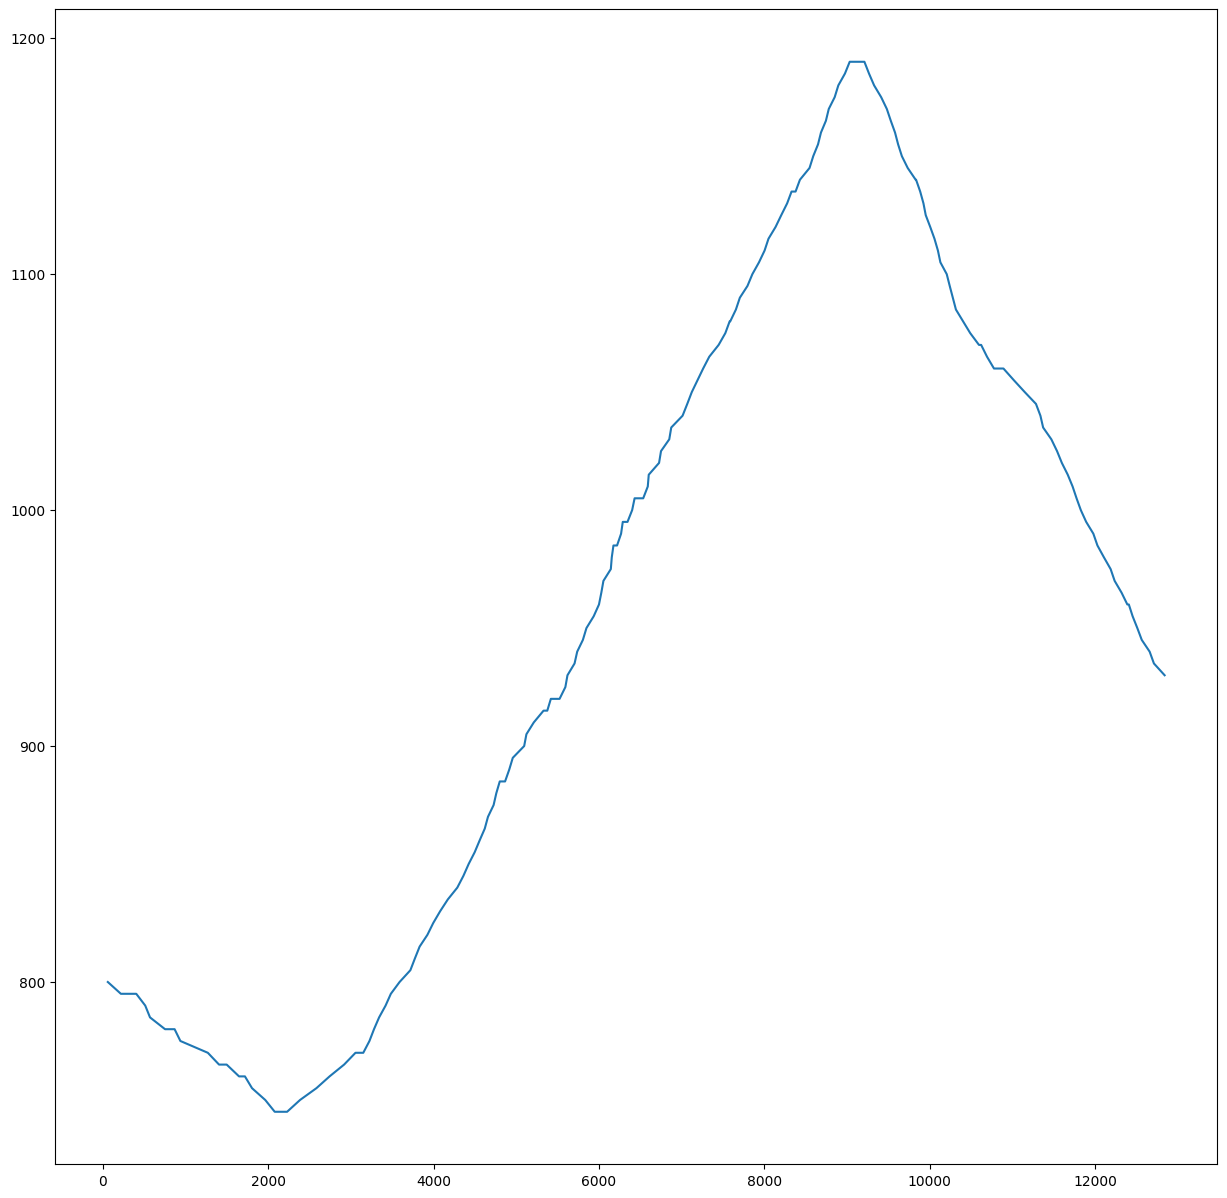

In [22]:
plt.rcParams['figure.figsize']=(15,15)
edge=edges[-13]
edge_df=intersection[intersection.edge==edge]
print(len(edge_df))
edge_df=edge_df.sort_values('edge_coordinate')
begin,end=edge_df.iloc[0]['geometry'],edge_df.iloc[-1]['geometry']
print(begin.y,begin.x)
print(end.y,end.x)
X,Y=np.array(edge_df['edge_coordinate']),np.array(edge_df['elevation'])
dY=np.diff(Y)
d_pos,deg=np.sum(np.where(dY>0,dY,0)),np.sum(np.where(dY<0,dY,0))
print('min:%f, max:%f, d+:%f, d-:%f'%(np.min(Y),np.max(Y),d_pos,deg))
plt.plot(X,Y)

min:745.000000, max:1190.000000, d+:445.000000, d-:-315.000000


/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


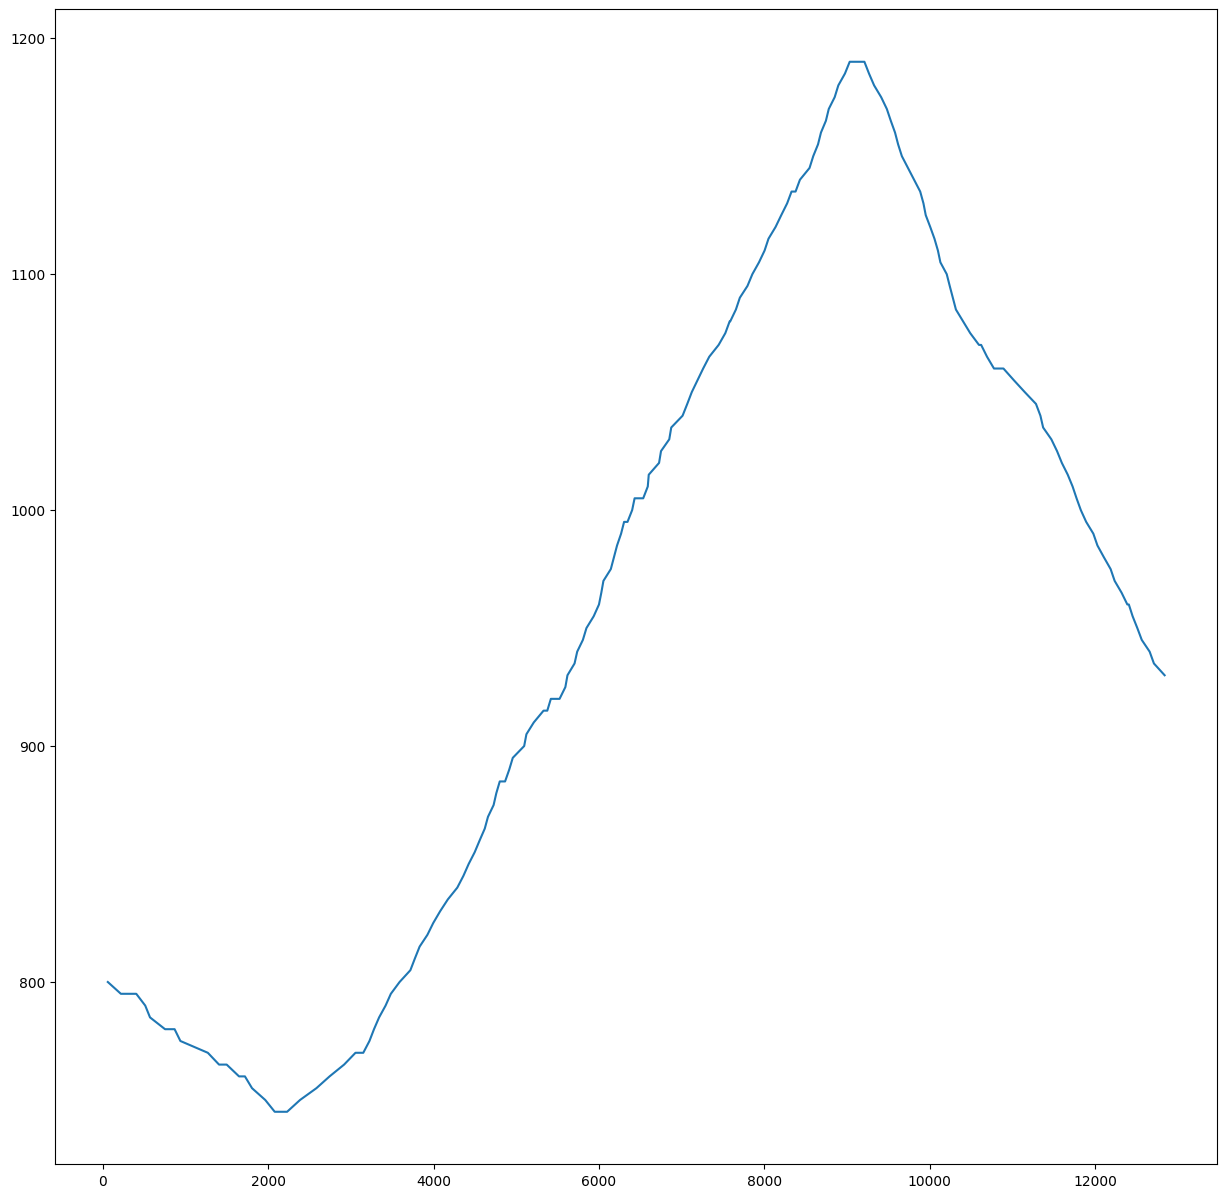

In [23]:
thresh=0.005
indexes=np.where(np.abs(np.gradient(np.gradient(Y,X),X))<=thresh)
X,Y=X[indexes],Y[indexes]
dY=np.diff(Y)
d_pos,deg=np.sum(np.where(dY>0,dY,0)),np.sum(np.where(dY<0,dY,0))
print('min:%f, max:%f, d+:%f, d-:%f'%(np.min(Y),np.max(Y),d_pos,deg))
plt.plot(X,Y)

In [139]:
thresh,min_df_size=0.005,1
t1=time.time()
bad_ids=[]
for edge in edges[::-1]:
    edge_df=intersection[intersection.edge==edge]
    if len(edge_df)>min_df_size:
        edge_df=edge_df.sort_values('edge_coordinate')
        X,Y=np.array(edge_df['edge_coordinate']),np.array(edge_df['elevation'])
        indexes=np.where(np.abs(np.gradient(np.gradient(Y,X),X))>thresh)
        bad_ids+=list(edge_df.index[indexes])
t2=time.time()
print(t2-t1)

/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/pie

100.74702620506287


In [140]:
len(bad_ids)/len(intersection)

0.01675872825997725

In [144]:
DELETE=False
if DELETE:
    t1=time.time()
    cmd="""DELETE FROM %s WHERE id IN  %s ;"""%(osm_intersections_table_name,str(tuple(bad_ids)))
    cursor.execute(cmd)
    t2=time.time()
    print(t2-t1)

0.058516502380371094
